# Predecting requirement for maintainenance for Birds

Let's start with importing what we will need. Given that the dataset is small we will use simple libraries such as pandas and sklearn.

In [138]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn import cross_validation
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

Let's import the csv file and see the raw features:

In [139]:
rides_raw = pd.read_csv("rides.csv")
rides_raw.describe()

,bird_id,bird_model_id,start_odometer,end_odometer,start_timestamp,end_timestamp,rider_id,rider_age,ride_rating
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,5.000000e+04,50000.000000,50000.000000,50000.000000
mean,247.838220,1.407460,1145.339987,1168.278776,1.523064e+09,1.523070e+09,49.489340,42.333920,3.625680
std,144.516275,0.491367,686.463628,686.633491,2.864743e+05,2.865393e+05,28.872681,13.578946,1.520148
min,0.000000,1.000000,0.000000,1.140000,1.522542e+09,1.522545e+09,0.000000,18.000000,1.000000
25%,122.000000,1.000000,558.895000,582.685000,1.522820e+09,1.522826e+09,25.000000,31.000000,2.000000
50%,248.000000,1.000000,1128.300000,1152.090000,1.523057e+09,1.523063e+09,49.000000,42.000000,4.000000
75%,373.000000,2.000000,1701.665000,1726.242500,1.523296e+09,1.523302e+09,75.000000,54.000000,5.000000
max,499.000000,2.000000,2967.740000,2985.710000,1.523858e+09,1.523867e+09,99.000000,65.000000,5.000000


Let's make sure everything got imported correctly with correct data type:

In [140]:
rides_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
bird_id                       50000 non-null int64
bird_model_id                 50000 non-null int64
start_odometer                50000 non-null float64
end_odometer                  50000 non-null float64
start_timestamp               50000 non-null int64
end_timestamp                 50000 non-null int64
rider_id                      50000 non-null int64
rider_age                     50000 non-null int64
ride_rating                   50000 non-null int64
ride_neighborhood             50000 non-null object
ride_triggered_maintenance    50000 non-null bool
dtypes: bool(1), float64(2), int64(7), object(1)
memory usage: 3.9+ MB


Let's look for missing data. Checking to see if any cleanup is needed:

In [141]:
rides_raw.isnull().sum()

bird_id                       0
bird_model_id                 0
start_odometer                0
end_odometer                  0
start_timestamp               0
end_timestamp                 0
rider_id                      0
rider_age                     0
ride_rating                   0
ride_neighborhood             0
ride_triggered_maintenance    0
dtype: int64

No missing data. Let's convert our target label from boolean to int so we can work with it better.

In [142]:
rides_raw["ride_triggered_maintenance"] = rides_raw["ride_triggered_maintenance"].astype(int)

Let's visualize data for each column and see if we have any anomalies that stand out in our data:

<IPython.core.display.Javascript object>


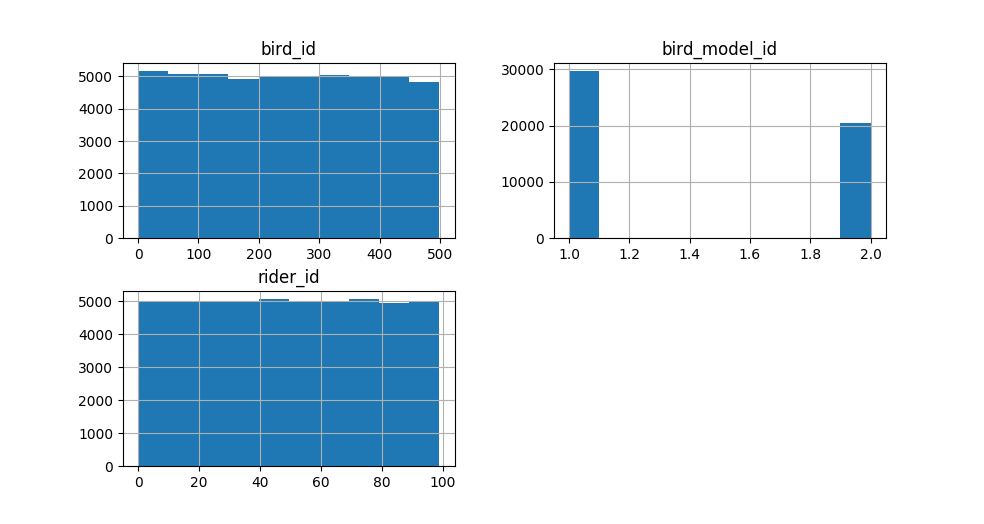

In [6]:
rides_raw.loc[:, ['bird_id','bird_model_id','rider_id']].hist();

5000 rides per rider_id sound odd if the time frame of the data is short. We will have to check the time stamps to make sure data actually corresponds to real users. The distribution of data in bird_id and rider_id seems artificially flat. They might not be responding to actual riders and birds.

Let's look at odometer data and also generate ride distance which might be a more meaningful feature for detecting maintenance requirement after the ride.

In [143]:
ride_distance = rides_raw['end_odometer'] - rides_raw['start_odometer']
rides_raw.insert(list(rides_raw.columns).index('end_odometer')+1, 'ride_distance', ride_distance)

<IPython.core.display.Javascript object>


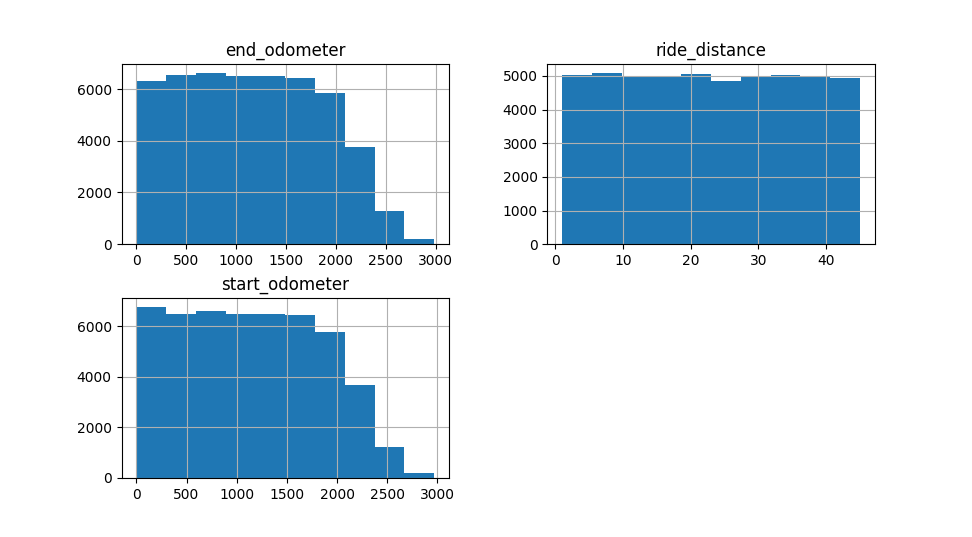

In [7]:
rides_raw.loc[:, 'start_odometer':'ride_distance'].hist();

Now let's look at some time information. Also generate some new features that can better explain the need for maintenance, such as ride time, ride's day in a week or month, its month, and its year.

In [144]:
rides_raw.insert(list(rides_raw.columns).index('start_timestamp')+1, "start_datetime", pd.to_datetime(rides_raw["start_timestamp"], unit='s'))
rides_raw.insert(list(rides_raw.columns).index('end_timestamp')+1, "end_datetime", pd.to_datetime(rides_raw["end_timestamp"], unit='s'))
rides_raw.insert(list(rides_raw.columns).index('start_datetime')+1, "start_year", rides_raw['start_datetime'].map(lambda x:x.year))
rides_raw.insert(list(rides_raw.columns).index('start_datetime')+1, "start_month", rides_raw['start_datetime'].map(lambda x:x.month))
rides_raw.insert(list(rides_raw.columns).index('start_datetime')+1, "start_day", rides_raw['start_datetime'].map(lambda x:x.day))
rides_raw.insert(list(rides_raw.columns).index('start_datetime')+1, "start_day_of_week", rides_raw['start_datetime'].map(lambda x:x.weekday())) # 0 is monday - 6 is sunday
ride_time = rides_raw['end_timestamp'] - rides_raw['start_timestamp']
rides_raw.insert(list(rides_raw.columns).index('end_datetime')+1, 'ride_time', ride_time)

<IPython.core.display.Javascript object>


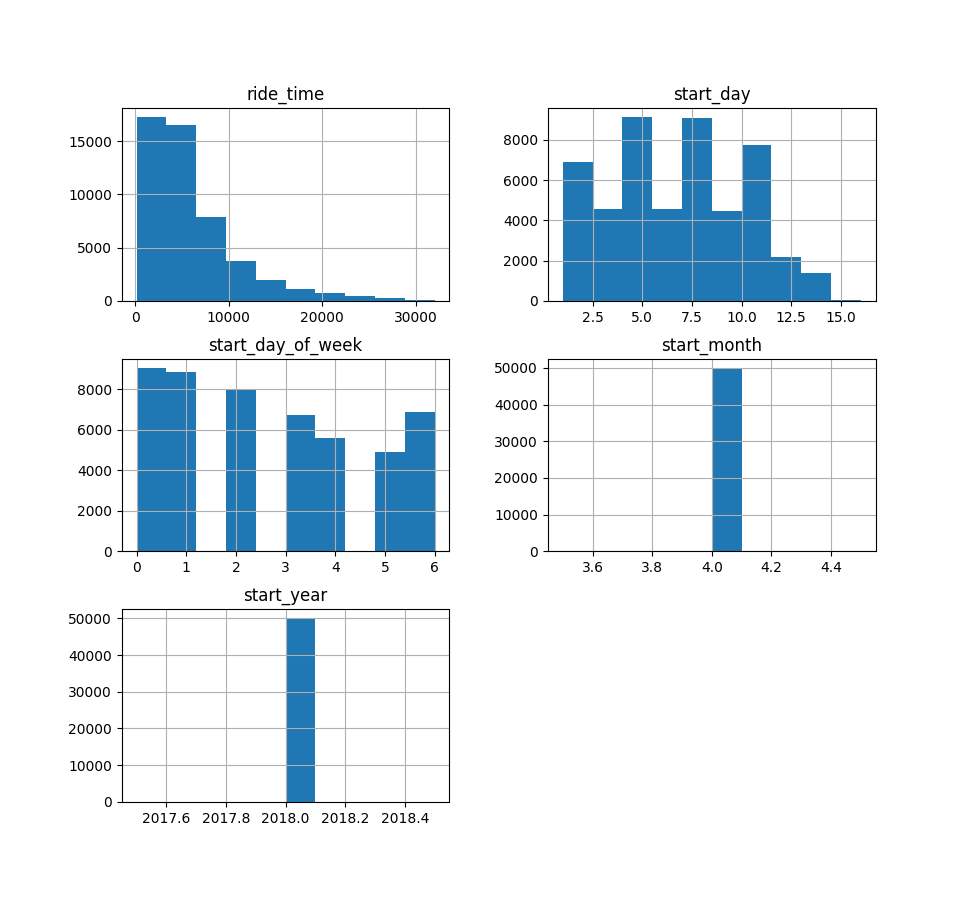

In [10]:
rides_raw.loc[:, ['start_year', 'start_month', 'start_day', 'start_day_of_week', 'ride_time']].hist();

Seems like all the data we have is for less than half month in Apr 2018. So it might be useful to use year, month, and day of the month since we don't have a complete distribution for each.

Also now that we know the data comes from a very small time slot, it is very likely that our rider_id and bird_id are not really associated with real people or birds.

Let's double check the legitimacy of rider_id by plotting the maintenance flag on each day for a random bird_id.

<IPython.core.display.Javascript object>


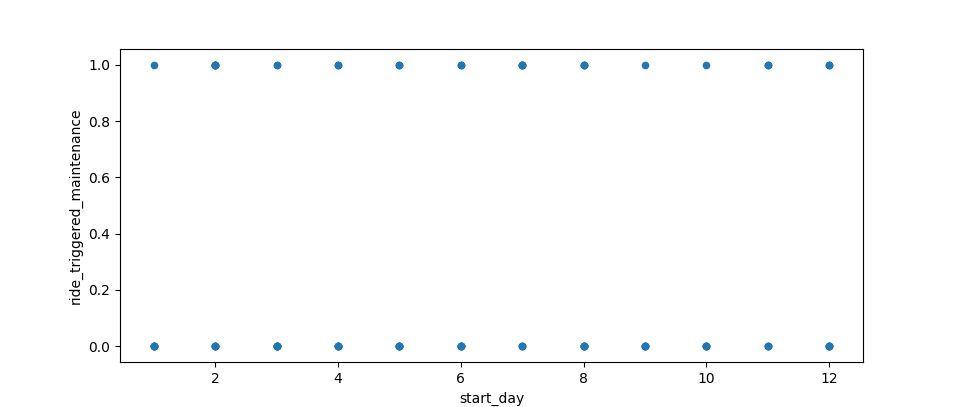

In [10]:
rides_raw.groupby('bird_id').get_group(random.randint(1,len(rides_raw['bird_id'].unique()))).plot.scatter(x='start_day',y='ride_triggered_maintenance');

As we can see the same bird_id has been flagged both bad and good on the same day almost every day. We cannot use bird_id as reliable ID for a physical bird.

<IPython.core.display.Javascript object>


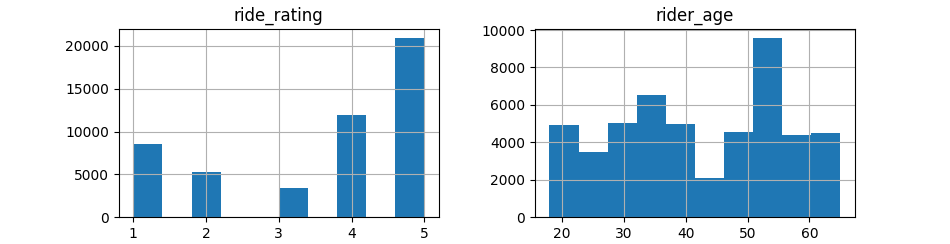

In [11]:
rides_raw.loc[:, ['rider_age', 'ride_rating']].hist();

Rating is bimodal

We have a peak usage in higher age groups (above 50) which is very suspicious. But if it is true the more power to them! :)

<IPython.core.display.Javascript object>


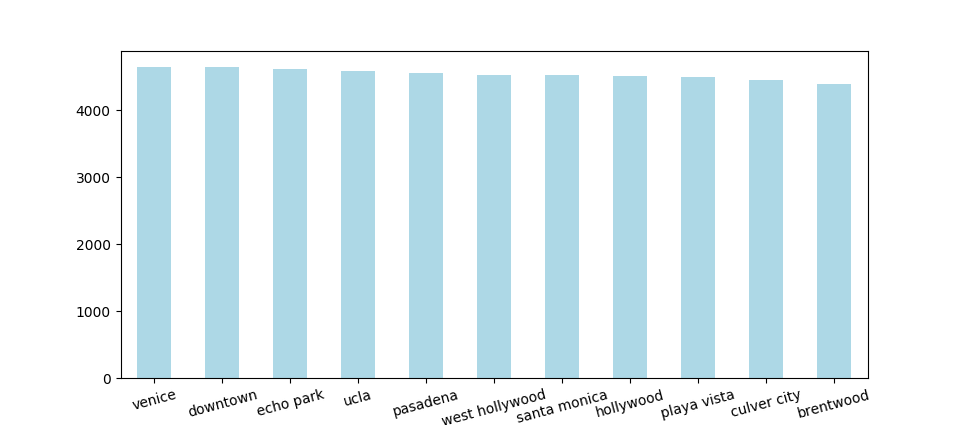

In [12]:
rides_raw['ride_neighborhood'].value_counts().plot(kind='bar', color='lightblue', rot=15);

Pretty much a flat distribution among neighborhoods.

<IPython.core.display.Javascript object>


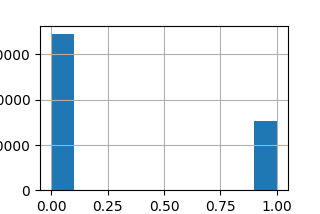

In [13]:
rides_raw.loc[:, 'ride_triggered_maintenance'].hist();

keeping in mind the target is imbalanced.

Let's make few more plots to make sure our rider_id and bird_id are indeed not relevant.
First, let's look at the distribution of random rider_id in each neighborhood.

<IPython.core.display.Javascript object>


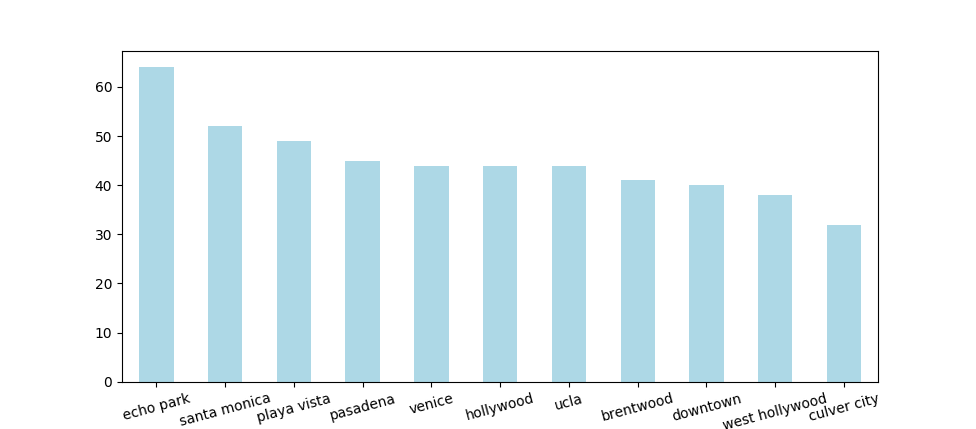

In [14]:
rides_raw.groupby('rider_id').get_group(random.randint(1,len(rides_raw['rider_id'].unique())))['ride_neighborhood'].value_counts().plot(kind='bar', color='lightblue', rot=15);

Wow. This definitely means rider_id is not tracking physical riders.

Now let's look at the distribution of a random bird_id in different neighborhoods

<IPython.core.display.Javascript object>


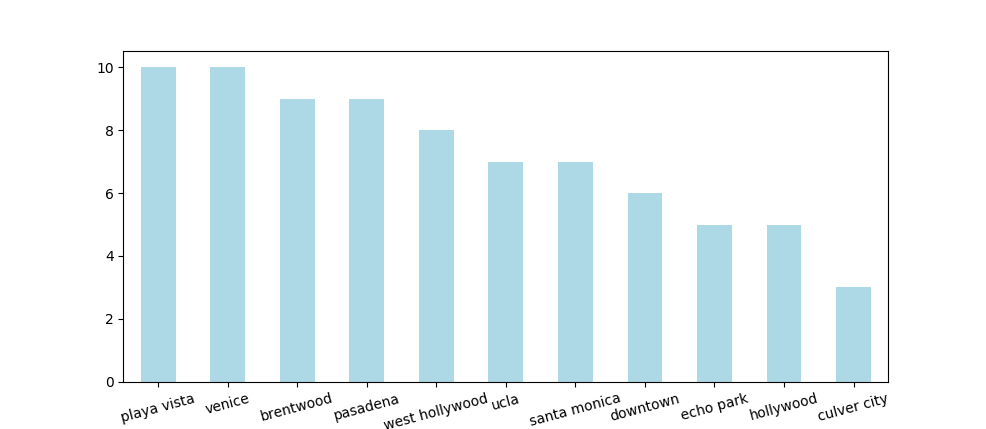

In [15]:
rides_raw.groupby('bird_id').get_group(random.randint(0,len(rides_raw['bird_id'].unique())))['ride_neighborhood'].value_counts().plot(kind='bar', color='lightblue', rot=15);

It seems like bird_id is not tracking physical scooters in either.

It seems like bird_id and rider_id have been anonymized, which I understand but they have been anonymized in a way that it is impossible to track one user or the same scooter across different rides. This prevents us to easily evaluate a few key hypotheses. For example, I highly suspect that it is not only the last ride that contributes to triggering the maintenance flag but the history of rides for a scooter from last maintenance is a contributor. But unfortunately, I cannot track one physical scooter in the data set. Also, I cannot investigate any effect that certain riders might have on triggering maintenance flag.

Since bird_id and rider_id are irrelevant, then age is also irrelevant. We will exclude redundant and irrelevant features from the dataset and turn neighborhood data to numbers so we can analyze it.

In [154]:
rides = rides_raw[['bird_model_id','ride_distance','end_odometer','start_day_of_week','ride_time', 'ride_rating', 'ride_neighborhood', 'ride_triggered_maintenance']].copy()
neighborhood_labels = rides_raw['ride_neighborhood'].astype('category').cat.categories.tolist()
replace_map_comp = {'ride_neighborhood' : {k: v for k,v in zip(neighborhood_labels,list(range(len(neighborhood_labels))))}}
rides.replace(replace_map_comp, inplace=True)
rides.head()

,bird_model_id,ride_distance,end_odometer,start_day_of_week,ride_time,ride_rating,ride_neighborhood,ride_triggered_maintenance
0,1,5.90,5.90,6,1872,1,5,0
1,1,29.33,29.33,6,6998,4,10,0
2,1,17.45,17.45,0,2186,5,1,1
3,1,26.67,26.67,6,10714,4,9,0
4,1,30.52,30.52,6,5120,5,1,1


Now let's figure out if our features have any information about our target label.

First, let's look at categorical columns and use chi-square to see if they are good features to be used in our model

In [155]:
def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]

    return stats.chi2_contingency(result) + (np.array(result),)

In [156]:
categorical_columns = np.array(["bird_model_id", "start_day_of_week", "ride_neighborhood", "ride_rating"])
p_values = np.array(list(map(lambda x:chi_square_of_df_cols(rides, x, 'ride_triggered_maintenance')[1], categorical_columns)))
categorical_columns[p_values<0.05]

array(['start_day_of_week', 'ride_rating'], dtype='<U17')

Seems like bird_model_id and ride_neighborhood have no or limited information for prediction requirement for maintenance. Let's exclude them from our model to decrease dimension of our input features.

In [157]:
rides_for_linear = rides.drop(columns=categorical_columns[p_values>=0.05])
rides_for_linear.head()

,ride_distance,end_odometer,start_day_of_week,ride_time,ride_rating,ride_triggered_maintenance
0,5.90,5.90,6,1872,1,0
1,29.33,29.33,6,6998,4,0
2,17.45,17.45,0,2186,5,1
3,26.67,26.67,6,10714,4,0
4,30.52,30.52,6,5120,5,1


Now, let's look at continuous features and see if they have any information for our model. We will use FANOVA to drop irrelevant features:

In [158]:
groups = rides.groupby("ride_triggered_maintenance").groups
continuous_cols = np.array(["ride_distance","end_odometer","ride_time"])
p_values = np.array(list(map(lambda x:stats.f_oneway(rides[x][groups[0]],rides[x][groups[1]])[1], continuous_cols)))
continuous_cols[p_values<0.05]

array(['end_odometer', 'ride_time'], dtype='<U13')

Seems like ride_distance has no or limited information for prediction requirement for maintenance. Let's exclude it from our model.

In [159]:
rides_for_linear = rides_for_linear.drop(columns=continuous_cols[p_values>=0.05])
rides_for_linear.head()

,end_odometer,start_day_of_week,ride_time,ride_rating,ride_triggered_maintenance
0,5.90,6,1872,1,0
1,29.33,6,6998,4,0
2,17.45,0,2186,5,1
3,26.67,6,10714,4,0
4,30.52,6,5120,5,1


Let's normalize the data:

In [161]:
min_max_scaler = preprocessing.MinMaxScaler()
rides_normalized = pd.DataFrame(min_max_scaler.fit_transform(rides), columns=rides.columns)
rides_normalized.head()

,bird_model_id,ride_distance,end_odometer,start_day_of_week,ride_time,ride_rating,ride_neighborhood,ride_triggered_maintenance
0,0.0,0.111364,0.001595,1.0,0.054714,0.00,0.5,0.0
1,0.0,0.643864,0.009445,1.0,0.215439,0.75,1.0,0.0
2,0.0,0.373864,0.005465,0.0,0.064560,1.00,0.1,1.0
3,0.0,0.583409,0.008554,1.0,0.331954,0.75,0.9,0.0
4,0.0,0.670909,0.009844,1.0,0.156555,1.00,0.1,1.0


In [162]:
rides_for_linear_normalized = pd.DataFrame(min_max_scaler.fit_transform(rides_for_linear), columns=rides_for_linear.columns)
rides_for_linear_normalized.head()

,end_odometer,start_day_of_week,ride_time,ride_rating,ride_triggered_maintenance
0,0.001595,1.0,0.054714,0.00,0.0
1,0.009445,1.0,0.215439,0.75,0.0
2,0.005465,0.0,0.064560,1.00,1.0
3,0.008554,1.0,0.331954,0.75,0.0
4,0.009844,1.0,0.156555,1.00,1.0


Split into train and test sets.

In [176]:
X_train, X_test, y_train, y_test = train_test_split(rides_for_linear_normalized.drop(columns=["ride_triggered_maintenance"]), rides_for_linear_normalized[["ride_triggered_maintenance"]], test_size=0.1, random_state=42)

Let's write a function to plot the Precision vs Recall curve after each model

In [164]:
def plotPR(predictions,y_test):
    average_precision = metrics.average_precision_score(y_test, predictions)
    precision, recall, _ = metrics.precision_recall_curve(y_test, predictions)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision));

Let's start with simple KNN classifer:

<IPython.core.display.Javascript object>


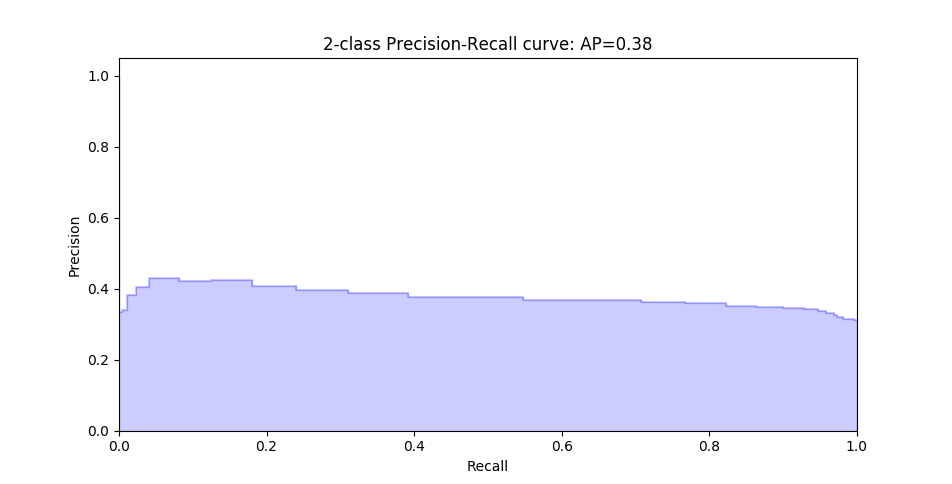

In [165]:
classifier = KNeighborsClassifier(n_neighbors=50)
classifier.fit(X_train, y_train)
predictions = classifier.predict_proba(X_test)[:,1]
plotPR(predictions,y_test)

Logistic regression:

/Users/emehr/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<IPython.core.display.Javascript object>


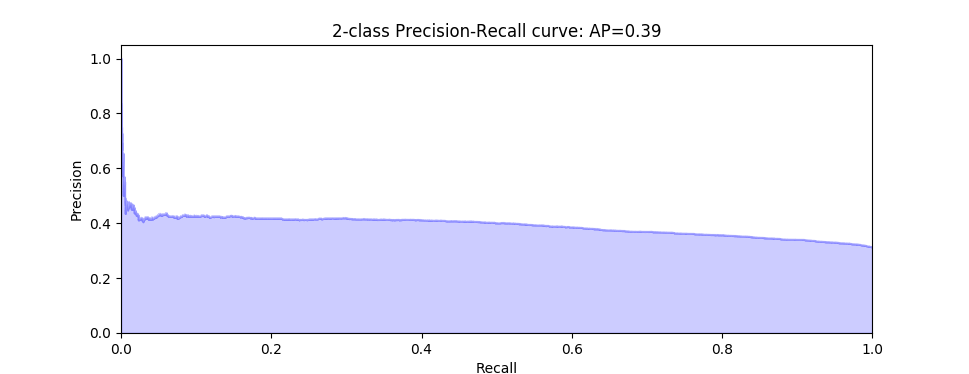

In [26]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.decision_function(X_test)
plotPR(predictions,y_test)

SVM:

/Users/emehr/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<IPython.core.display.Javascript object>


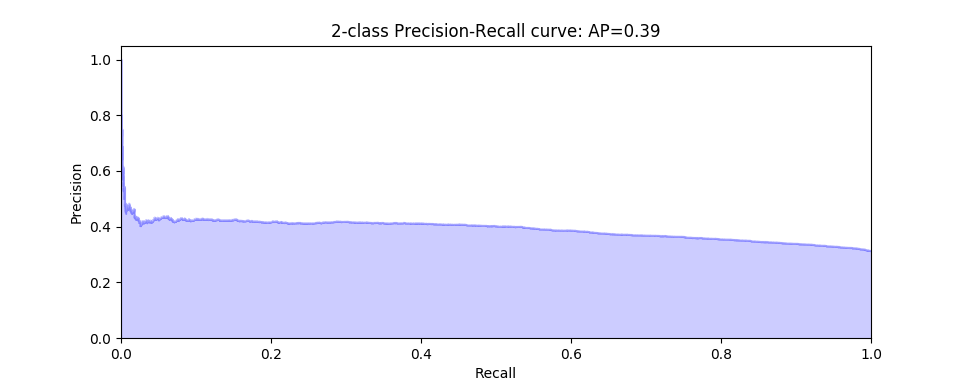

In [27]:
classifier = svm.LinearSVC(random_state=42)
classifier.fit(X_train, y_train)
predictions = classifier.decision_function(X_test)
plotPR(predictions,y_test)

Decision Trees:

<IPython.core.display.Javascript object>


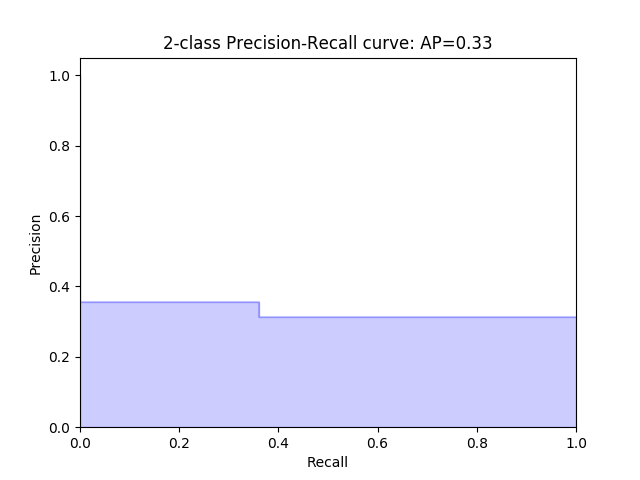

In [177]:
classifier = tree.DecisionTreeClassifier()
classifier.fit(X_train, y_train)
predictions = classifier.predict_proba(X_test)[:,1]
plotPR(predictions,y_test)

Neural network:

In [186]:
X_train, X_test, y_train, y_test = train_test_split(rides_normalized.drop(columns=["ride_triggered_maintenance"]), rides_normalized[["ride_triggered_maintenance"]], test_size=0.1, random_state=42)
classifier = MLPClassifier(hidden_layer_sizes=(30,30,30))
# hidden_layer_sizes=(100,100,100,100,100,100,100,100,100,100), max_iter=100000000, learning_rate_init=0.001, batch_size=1000, tol=0.0000000001, beta_1=0.9, beta_2=0.999, alpha=0.00000001

<IPython.core.display.Javascript object>


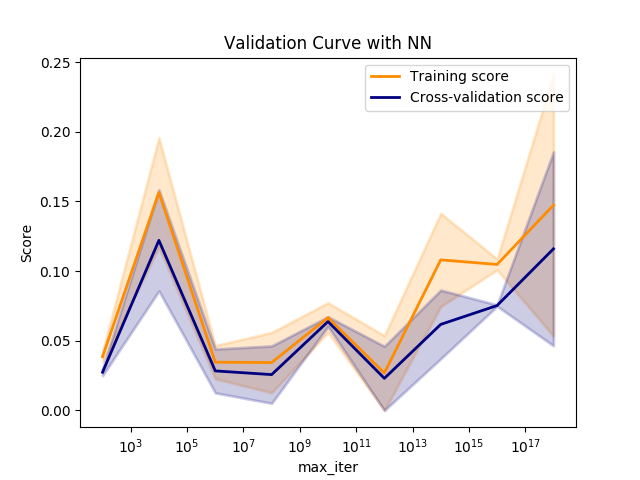

In [187]:
param_range=[100**exp for exp in range(1, 10)]
train_scores, test_scores = validation_curve(
    classifier, X_test, y_test, param_name="max_iter", param_range=param_range,
    cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=False), scoring="f1", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with NN")
plt.xlabel("max_iter")
plt.ylabel("Score")
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show();

In [188]:
classifier = MLPClassifier(hidden_layer_sizes=(30,30,30), max_iter=10**4)

In [189]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring="f1", cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<IPython.core.display.Javascript object>


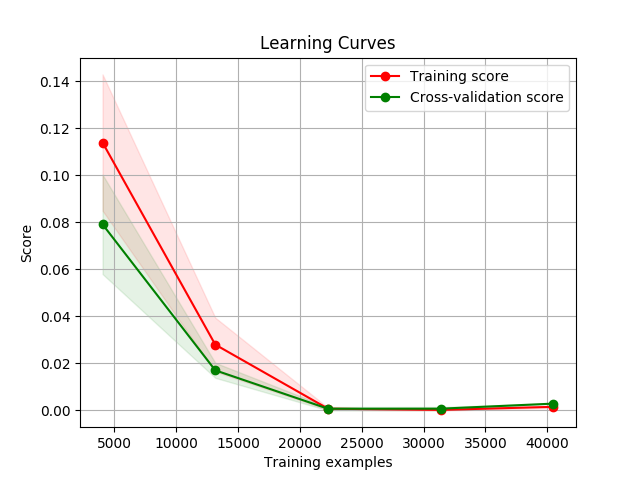

In [190]:
# Cross validation with 2 iterations
# score curves, each time with 10% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(X_train.shape[0], n_iter=2, test_size=0.1, random_state=42)
plot_learning_curve(classifier, "Learning Curves", X_train, y_train, cv=cv, n_jobs=1).show();

In [191]:
classifier.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(30, 30, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

<IPython.core.display.Javascript object>


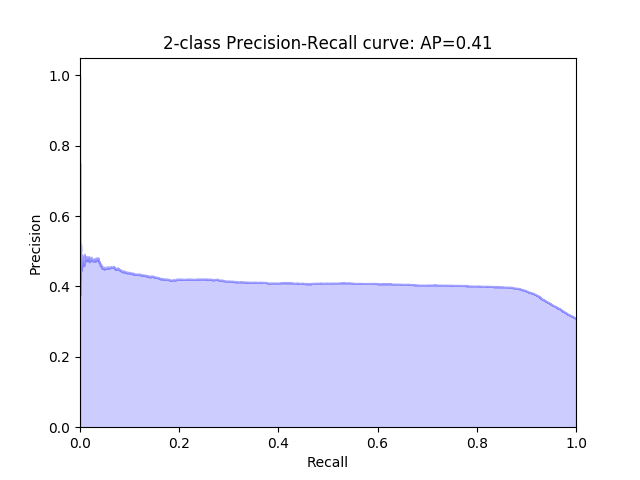

In [192]:
train_predictions = classifier.predict_proba(X_train)[:,1]
plotPR(train_predictions,y_train)

<IPython.core.display.Javascript object>


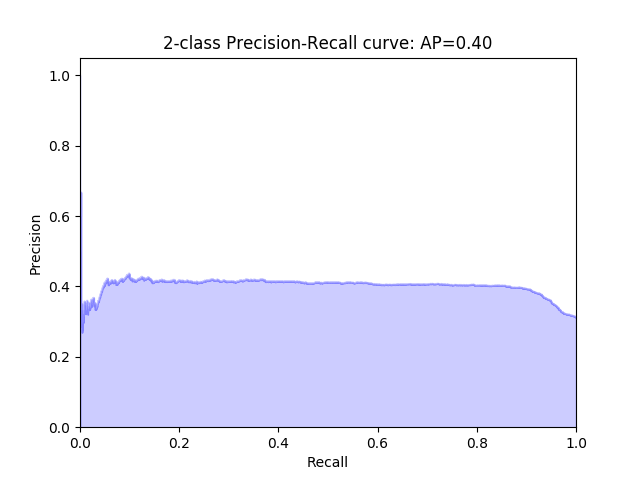

In [193]:
predictions = classifier.predict_proba(X_test)[:,1]
plotPR(predictions,y_test)

On a separate script, I also did some hyperparameter tuning but unfortunately couldn't make any significant improvement, beyond 40% average precision. So our model outperforms a random choice by less than 10%. This means we probably need better features to create this model and current features don't have enough information for this prediction task.